# Language Identification in South African Text: Kaggle Competition

This notebook presents my approach to tackle the Language Identification Challenge on Kaggle. The challenge focuses on classifying text written in South Africa's 11 Official languages. The notebook covers data exploration, preprocessing, feature extraction, model training, evaluation, and submission generation. By leveraging machine learning techniques, I aim to develop a classification model that accurately predicts the language of a given text.

Honour Code
I **MPHO SESINYI**, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the EDSA honour code.

Non-compliance with the honour code constitutes a material breach of contract.

## Importing necessary libraries

In [1]:
from google.colab import files
uploaded = files.upload()

Saving train_set.csv to train_set.csv


In [2]:
from google.colab import files
uploaded = files.upload()

Saving test_set (1).csv to test_set (1).csv


In [3]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission (2).csv to sample_submission (2).csv


In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import resample
from sklearn import feature_selection
from sklearn.feature_selection import f_classif
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn import preprocessing


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import datetime

## Loading the data

In [6]:
train_df = pd.read_csv('train_set.csv')
test_df = pd.read_csv('test_set (1).csv')
sample_submission_df = pd.read_csv('sample_submission (2).csv')

## Exploratory Data Analysis (EDA)

In [7]:
print("Train Dataset:")
print(train_df.head())

print("\nTest Dataset:")
print(test_df.head())


Train Dataset:
  lang_id                                               text
0     xho  umgaqo-siseko wenza amalungiselelo kumaziko ax...
1     xho  i-dha iya kuba nobulumko bokubeka umsebenzi na...
2     eng  the province of kwazulu-natal department of tr...
3     nso  o netefatša gore o ba file dilo ka moka tše le...
4     ven  khomishini ya ndinganyiso ya mbeu yo ewa maana...

Test Dataset:
   index                                               text
0      1  Mmasepala, fa maemo a a kgethegileng a letlele...
1      2  Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2      3         Tshivhumbeo tshi fana na ngano dza vhathu.
3      4  Kube inja nelikati betingevakala kutsi titsini...
4      5                      Winste op buitelandse valuta.


In [8]:
train_df.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [9]:
test_df.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


In [13]:
shape = train_df.shape
print('The shape of the dataset: ', shape)

The shape of the dataset:  (33000, 2)


In [14]:
test_df.shape

(5682, 2)

The training data consists of 33000 rows and 2 columns, whereas the test data comprises 5682 rows and 2 columns.

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5682 entries, 0 to 5681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   5682 non-null   int64 
 1   text    5682 non-null   object
dtypes: int64(1), object(1)
memory usage: 88.9+ KB


In [17]:
train_df.isnull().sum()

lang_id    0
text       0
dtype: int64

In [18]:
test_df.isnull().sum()

index    0
text     0
dtype: int64

In [19]:
print(train_df.isnull())

       lang_id   text
0        False  False
1        False  False
2        False  False
3        False  False
4        False  False
...        ...    ...
32995    False  False
32996    False  False
32997    False  False
32998    False  False
32999    False  False

[33000 rows x 2 columns]


In [20]:
print(test_df.isnull())

      index   text
0     False  False
1     False  False
2     False  False
3     False  False
4     False  False
...     ...    ...
5677  False  False
5678  False  False
5679  False  False
5680  False  False
5681  False  False

[5682 rows x 2 columns]


In [21]:
# Group by 'lang_id' and count occurrences
language_counts = train_df.groupby('lang_id').size().reset_index(name='count')

# Sort by 'count' in descending order
language_counts_sorted = language_counts.sort_values(by='count', ascending=False)

# Display the result
language_counts_sorted

,lang_id,count
0,afr,3000
1,eng,3000
2,nbl,3000
3,nso,3000
4,sot,3000
5,ssw,3000
6,tsn,3000
7,tso,3000
8,ven,3000
9,xho,3000


In [22]:
# Identify and extract rows with duplicated 'text' and 'language Id'
duplicates = train_df[train_df[['text', 'lang_id']].duplicated(keep=False)].count()

# Display the DataFrame containing duplicate rows
duplicates['text']

5599

In [23]:
# Count the occurrences of each duplicate texts
text_counts = train_df['text'].value_counts()

# Display the result
text_counts.head(10)

ngokwesekhtjheni yomthetho ophathelene nalokhu unelungelo lokudlulisela isililo sakho kusomkhandlu wezehlalakuhle ngokutlola incwadi uyithumele e-adresini elandelako kungakapheli amalanga amatjhumi alithoba ukusukela mhlazana uthola incwadi le                                               17
ukubhalelwa kuzalisa iimfuneko zomthetho ophathelene nalokhu kungawufelelisa umrholwakho naweqisa iinyanga ezintathu ngokulandelana ungawuthathi umrholwakho nakhona uzakufelela umrholo owuthole ngokungakafaneli kufuze uwubuyise                                                               14
imali osalele ngayo emva nayo seyifakiwe emrholweni wakho wokuthoma nakungenzeka ukuthi imali le ibe yinengi ukudlula isilinganiso sephrovinsi yangekhenu izakuhlukaniswa ngeenyanga eziimbadlwana malungana nalokhu thintana ne-ofisi yezehlalakuhle yangekhenu nawufuna eminye imininingwana    13
sibawa abafakazeli ababili esingakghona ukubathola umrholi womphakathi kunye nesikghwari esiwufundeleko umsebenzi wobukgh

In [24]:
# Create an EDA dataset
eda_df = train_df.copy()

# Display the cleaning dataset
eda_df

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...
...,...,...
32995,tsn,popo ya dipolateforomo tse ke go tlisa boetele...
32996,sot,modise mosadi na o ntse o sa utlwe hore thaban...
32997,eng,closing date for the submission of completed t...
32998,xho,nawuphina umntu ofunyenwe enetyala phantsi kwa...


In [25]:
# Create an EDA test dataset
eda_test_df = test_df.copy()

# Display the cleaning dataset
eda_test_df

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.
...,...,...
5677,5678,You mark your ballot in private.
5678,5679,Ge o ka kgetha ka bowena go se šomiše Mofani k...
5679,5680,"E Ka kopo etsa kgetho ya hao ka hloko, hobane ..."
5680,5681,"TB ke bokudi ba PMB, mme Morero o tla lefella ..."


In [26]:
eda_df = eda_df.drop_duplicates()

In [27]:
eda_df.shape

(29948, 2)

In [28]:
from wordcloud import WordCloud

In [29]:
word_string_lang =" ".join(eda_df['lang_id'])
word_string_text =" ".join(eda_df['text'])

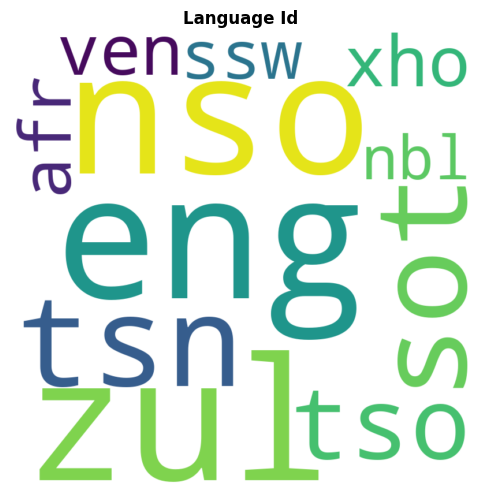

In [30]:
plt.figure(figsize=(6, 6))
plt.title("Language Id", fontweight='bold')
wc_lang = WordCloud(background_color="white", max_words=500, max_font_size=300, width=800, height=800)
wc_lang.generate(word_string_lang)
plt.imshow(wc_lang.recolor(colormap='viridis', random_state=17), interpolation="bilinear")
plt.axis('off')
plt.show()

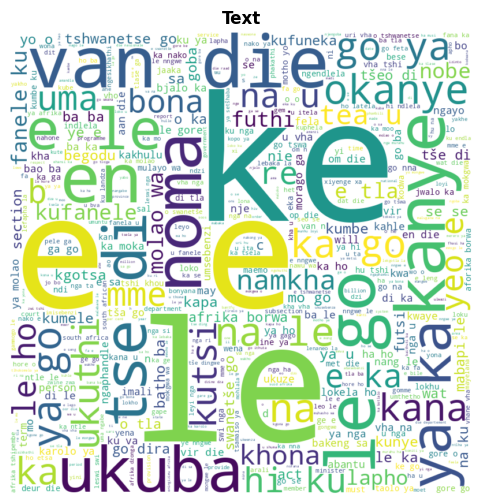

In [31]:
plt.figure(figsize=(6, 6))
plt.title("Text", fontweight='bold')
wc_text = WordCloud(background_color="white", max_words=500, max_font_size=300, width=800, height=800)
wc_text.generate(word_string_text)
plt.imshow(wc_text.recolor(colormap='viridis', random_state=17), interpolation="bilinear")
plt.axis('off')
plt.show()

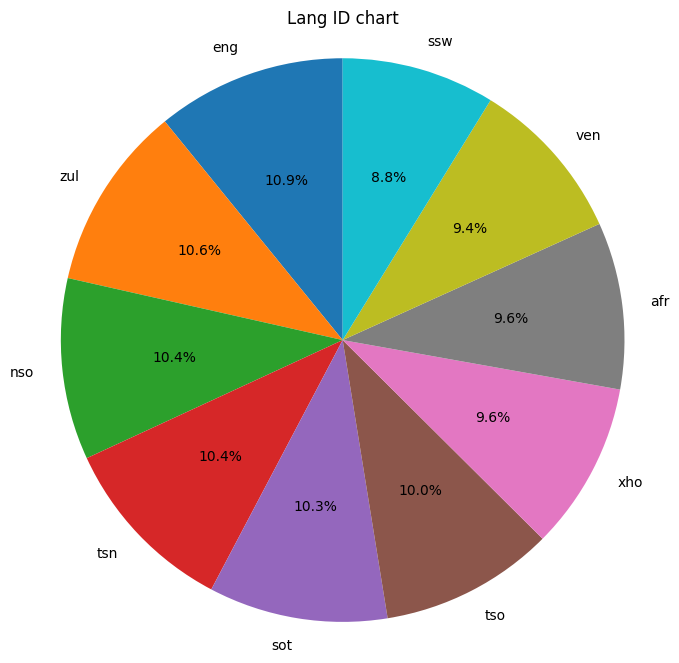

In [32]:
lang_ID_counts = eda_df['lang_id'].value_counts().head(10)

plt.figure(figsize=(8, 8))
plt.pie(lang_ID_counts, labels=lang_ID_counts.index, autopct='%1.1f%%', startangle=90,)

plt.axis('equal')
plt.title('Lang ID chart')
plt.show()

In [33]:
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [34]:
# Convert all text in the 'text' column to lowercase
eda_df['text'] = eda_df['text'].str.lower()

# Display the updated DataFrame
eda_df

<ipython-input-34-102c96080778>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_df['text'] = eda_df['text'].str.lower()


,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...
...,...,...
32994,eng,manuel marin s ill-fated debt sources but very...
32995,tsn,popo ya dipolateforomo tse ke go tlisa boetele...
32997,eng,closing date for the submission of completed t...
32998,xho,nawuphina umntu ofunyenwe enetyala phantsi kwa...


In [35]:
# Convert all text in the 'text' column to lowercase
eda_test_df['text'] = eda_test_df['text'].str.lower()

# Display the updated DataFrame
eda_test_df

,index,text
0,1,"mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,tshivhumbeo tshi fana na ngano dza vhathu.
3,4,kube inja nelikati betingevakala kutsi titsini...
4,5,winste op buitelandse valuta.
...,...,...
5677,5678,you mark your ballot in private.
5678,5679,ge o ka kgetha ka bowena go se šomiše mofani k...
5679,5680,"e ka kopo etsa kgetho ya hao ka hloko, hobane ..."
5680,5681,"tb ke bokudi ba pmb, mme morero o tla lefella ..."


# **Text Cleaning**

In [40]:
# Create a cleaning dataset by copying the 'eda_df' DataFrame
df_clean = eda_df.copy()

# Display the cleaning dataset
df_clean

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...
...,...,...
32994,eng,manuel marin s ill-fated debt sources but very...
32995,tsn,popo ya dipolateforomo tse ke go tlisa boetele...
32997,eng,closing date for the submission of completed t...
32998,xho,nawuphina umntu ofunyenwe enetyala phantsi kwa...


In [41]:
# Create a cleaning dataset by copying the 'eda_df' DataFrame
df_test_clean = eda_test_df.copy()

# Display the cleaning dataset
df_test_clean

,index,text
0,1,"mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,tshivhumbeo tshi fana na ngano dza vhathu.
3,4,kube inja nelikati betingevakala kutsi titsini...
4,5,winste op buitelandse valuta.
...,...,...
5677,5678,you mark your ballot in private.
5678,5679,ge o ka kgetha ka bowena go se šomiše mofani k...
5679,5680,"e ka kopo etsa kgetho ya hao ka hloko, hobane ..."
5680,5681,"tb ke bokudi ba pmb, mme morero o tla lefella ..."


In [37]:
# Import regular expressions and string manipulation module
import re  # Regular expressions
import string  # String manipulation
import itertools  # Iteration tools
from collections import Counter  # Collection data type

In [38]:
# Display the set of punctuation characters
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [42]:
def remove_punctuation(text):
    return ''.join([p for p in text if p not in string.punctuation and p != '’'])

In [43]:
# Apply the remove_punctuation function to the 'text' column in clean_df
df_clean['text'] = df_clean['text'].apply(remove_punctuation)

# Display the updated DataFrame
df_clean.head()

,lang_id,text
0,xho,umgaqosiseko wenza amalungiselelo kumaziko axh...
1,xho,idha iya kuba nobulumko bokubeka umsebenzi nap...
2,eng,the province of kwazulunatal department of tra...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [44]:
# Apply the remove_punctuation function to the 'text' column in eda_df
df_test_clean['text'] = df_test_clean['text'].apply(remove_punctuation)

# Display the updated DataFrame
df_test_clean.head()

,index,text
0,1,mmasepala fa maemo a a kgethegileng a letlelel...
1,2,uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,tshivhumbeo tshi fana na ngano dza vhathu
3,4,kube inja nelikati betingevakala kutsi titsini...
4,5,winste op buitelandse valuta


In [45]:
# Function to remove numbers from text
def remove_numbers(text):
    unnumbered_string = re.sub(r'[0-9]', '', text)
    return unnumbered_string

# Apply the function to the data
df_clean["text"] =df_clean['text'].apply(remove_numbers)

In [46]:
# Function to remove numbers from text
def remove_numbers(text):
    unnumbered_string = re.sub(r'[0-9]', '', text)
    return unnumbered_string

# Apply the function to the data
df_test_clean["text"] =df_test_clean['text'].apply(remove_numbers)

In [48]:
# Create function to replace strange characters in data with closest ascii equivalent
def clean_text(text):
    # Normalize the text to remove diacritics and other special characters
    normalized_text = unicodedata.normalize('NFKD', text)

    # Remove or replace any remaining unwanted characters
    cleaned_text = normalized_text.encode('ascii', 'ignore').decode('utf-8')

    return cleaned_text.lower()

df_clean["text"] =df_clean['text'].apply(clean_text)

In [49]:
# Create function to replace strange characters in data with closest ascii equivalent
def clean_text(text):
    normalized_text = unicodedata.normalize('NFKD', text)

    cleaned_text = normalized_text.encode('ascii', 'ignore').decode('utf-8')

    return cleaned_text.lower()

df_test_clean["text"] =df_test_clean['text'].apply(clean_text)

In [50]:
def bag_of_words_count(words, word_dict={}):
    """ this function takes in a list of words and returns a dictionary
        with each word as a key, and the value represents the number of
        times that word appeared"""
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

In [51]:
# Join all texts within one string variable
complete_texts = " ".join(df_clean["text"])

# Split texts into list of words
word_list = complete_texts.split()

# Count words in dataset
word_count = {}
bag_of_words_count(word_list, word_count)

# Sort dictionary on word count
word_count = sorted(word_count.items(), key=lambda x:x[1], reverse=True)

print(word_count[0:20])

[('ya', 26274), ('a', 20127), ('le', 20058), ('ka', 17151), ('go', 16365), ('e', 14944), ('na', 10104), ('the', 10003), ('wa', 9316), ('die', 9047), ('u', 8961), ('ba', 8471), ('o', 8202), ('ho', 7938), ('ku', 7613), ('of', 7456), ('tsa', 7381), ('nga', 6239), ('di', 5325), ('in', 5266)]


In [52]:
word_list[:15]

['umgaqosiseko',
 'wenza',
 'amalungiselelo',
 'kumaziko',
 'axhasa',
 'ulawulo',
 'lwesininzi',
 'kunye',
 'nokuthath',
 'inxaxheba',
 'kwabafazi',
 'ezi',
 'ziquka',
 'phakathi',
 'kwezinye']

In [53]:
df_clean['text_length']=df_clean['text'].apply(lambda x: len(x))

In [54]:
# Put word counts into dataframe
df_wordcount = pd.DataFrame(word_count, columns=["Word", "Count"])

# Amount of rare words
rare_words = df_wordcount[df_wordcount["Count"] == 1]
print(len(rare_words), " words appear only once in our data, which is ", round(len(rare_words)/len(word_count)*100, 2), "% of all words in the dataset")

# Print 10 examples of rare words
print(list(rare_words["Word"])[:])

84988  words appear only once in our data, which is  59.48 % of all words in the dataset
['nokuthath', 'nobulumko', 'bokubeka', 'naphi', 'ngokusekwe', 'kokubonana', 'ulandulo', 'mayibize', 'kwajolwayo', 'ferry', 'dumelelanego', 'metelele', 'scaffolds', 'omo', 'faposiwang', 'ikarabele', 'sekiwa', 'mahatulele', 'madzhisitirata', 'laelwaho', 'dikhuduthamaga', 'thteramelao', 'ikrabela', 'benyabenyang', 'ukufna', 'dizainiwa', 'ngutekulima', 'kulima', 'nekungeta', 'kungumkhakha', 'etikwemnotfo', 'inemtselela', 'igross', 'elingazihluphi', 'umphathisikhundla', 'ngekheli', 'diseporo', 'thibelwago', 'nabangabasebenzi', 'nezimenenja', 'ngokunomqondo', 'wesikhala', 'esingakarhunyezwa', 'osekelako', 'ukhutjhwa', 'molebokakaretso', 'yimerile', 'mashimbye', 'stofkrag', 'bekatiwa', 'baloko', 'ngesakhe', 'bangabhekana', 'kungeyiwo', 'yenhlekelele', 'ekhungethe', 'ekhonferensini', 'yethungelelwano', 'lokwehluka', 'ekwembathiseni', 'yokubulungwa', 'kweensalela', 'zakasarah', 'sewutfolile', 'wabambisa', '

In [55]:
# Make dataframe of all word counts in the data
df_wordcounts = pd.DataFrame(df_clean['text'].str.split(expand=True).stack().value_counts())
df_wordcounts.reset_index(inplace=True)
df_wordcounts.rename(columns={"index": "word", 0:"count"}, inplace=True)

# Extract unique words from data
df_unique_words = df_wordcounts[df_wordcounts["count"]==1]
df_unique_words

# Investigate amount of unique words
print(len(df_unique_words), "out of", len(df_wordcounts), "words in our dataset appears only once, i.e.", str(round(len(df_unique_words)/len(df_wordcounts)*100, 2)) +"%", "of words used are unique")


84988 out of 142890 words in our dataset appears only once, i.e. 59.48% of words used are unique


In [56]:
# Make list of unique words
unique_wordlist = set(df_unique_words["word"])

# Function to remove unique words from data
def remove_unique_words(lang_text):
    words = lang_text.split()
    return ' '.join([t for t in words if t not in unique_wordlist])

# Applying the function
df_clean["text"] =df_clean['text'].apply(remove_unique_words)

In [57]:
df_clean.shape

(29948, 3)

In [58]:
df_clean['words_count'] = df_clean['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
df_clean

,lang_id,text,text_length,words_count
0,xho,umgaqosiseko wenza amalungiselelo kumaziko axh...,219,23
1,xho,idha iya kuba umsebenzi na kwisebe kwiimfuno z...,250,24
2,eng,the province of kwazulunatal department of tra...,263,35
3,nso,o netefatsa gore o ba file dilo ka moka tse le...,217,37
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,239,43
...,...,...,...,...
32994,eng,manuel marin s debt sources but very little fr...,238,40
32995,tsn,popo ya tse ke go tlisa boeteledipele ka mo ya...,272,43
32997,eng,closing date for the submission of completed t...,222,35
32998,xho,nawuphina umntu ofunyenwe enetyala phantsi kwa...,228,23


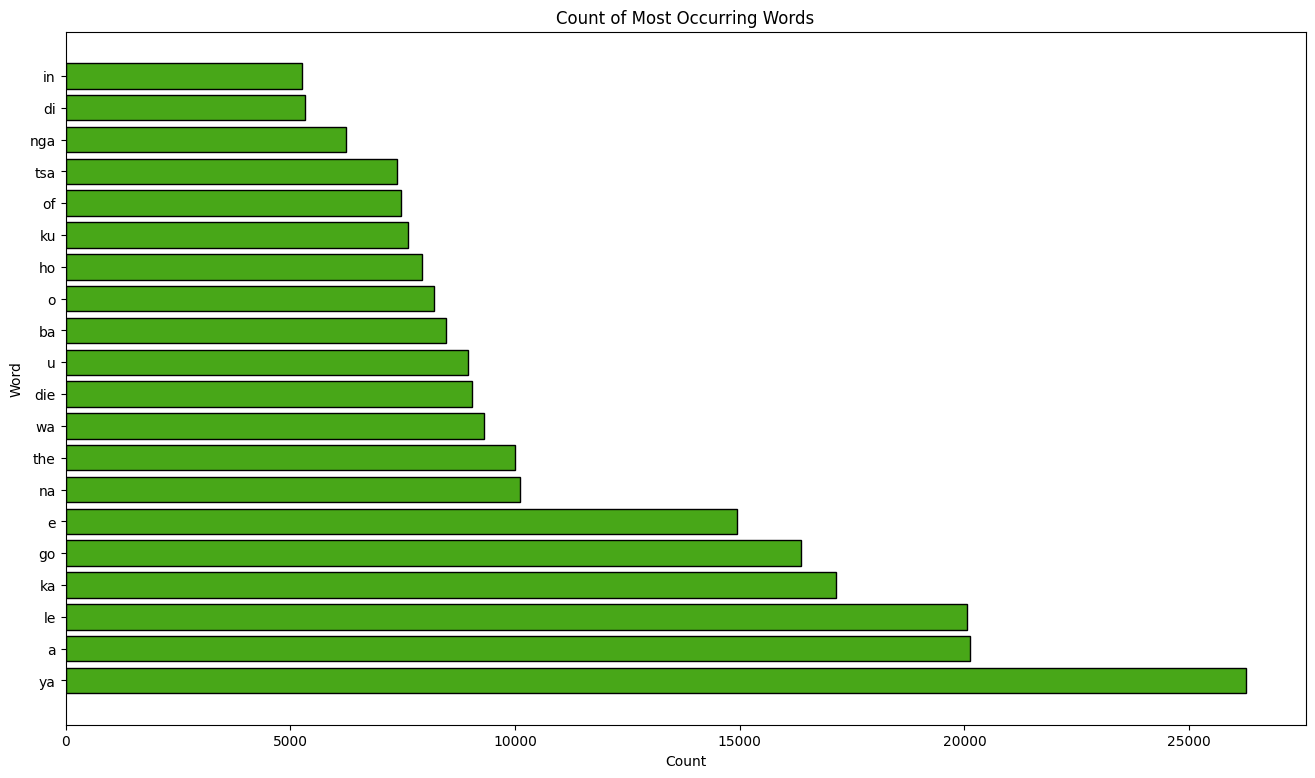

In [59]:
# Put word counts into dataframe
df_wordcount = pd.DataFrame(word_count, columns=["Word", "Count"])

# Select 20 most occurring words
df_to_plot = df_wordcount.head(20)

# Plot horizontal bar chart with borders
plt.figure(figsize=(16, 9))
bars = plt.barh(df_to_plot['Word'], df_to_plot['Count'], color='#48A718', edgecolor='black')

# Add borders to bars
for bar in bars:
    bar.set_edgecolor('black')

plt.title("Count of Most Occurring Words")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

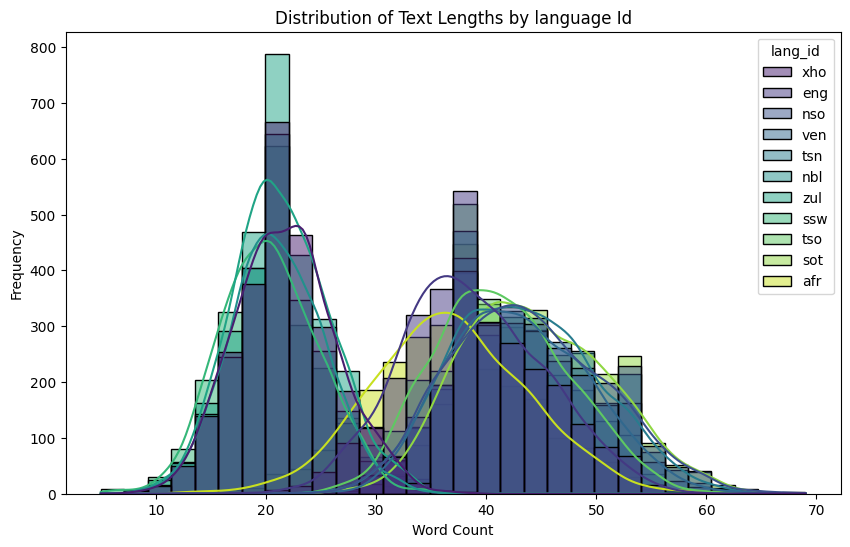

In [60]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_clean, x='words_count', hue='lang_id', kde=True, bins=30, palette='viridis')
plt.title('Distribution of Text Lengths by language Id')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

   lang_id  words_count
0      afr    36.657327
1      eng    38.756171
2      nbl    21.041914
3      nso    43.752872
4      sot    44.417579
5      ssw    20.344600
6      tsn    43.395957
7      tso    41.377085
8      ven    42.992322
9      xho    21.807822
10     zul    21.431601


<ipython-input-61-186c24bcbc11>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=average_word_count_by_lang, x='lang_id', y='words_count', palette='viridis')


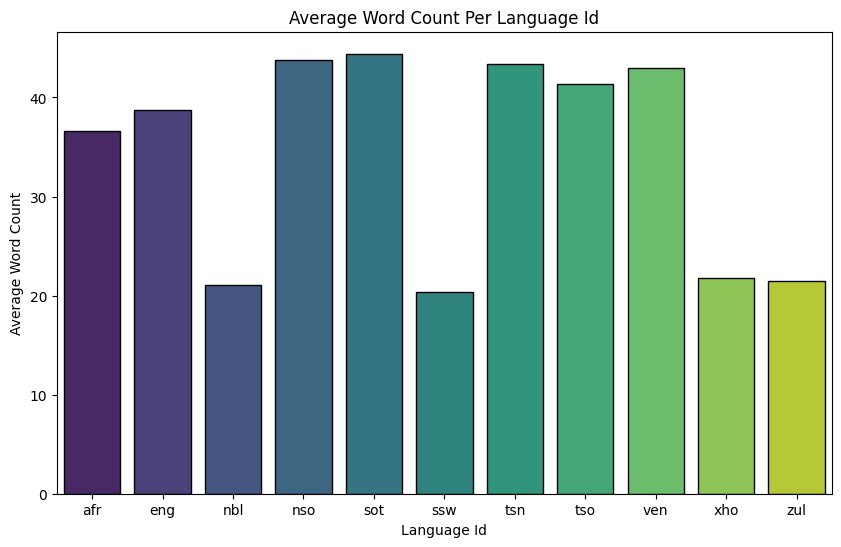

In [61]:
# Group by 'language Id' and calculate the average word count for each group
average_word_count_by_lang = df_clean.groupby('lang_id')['words_count'].mean().reset_index()

# Display the result
print(average_word_count_by_lang)

# Create a bar chart to visualize the average word count by language with borders
plt.figure(figsize=(10, 6))
bars = sns.barplot(data=average_word_count_by_lang, x='lang_id', y='words_count', palette='viridis')

# Add borders to bars
for bar in bars.patches:
    bar.set_edgecolor('black')

plt.title('Average Word Count Per Language Id')
plt.xlabel('Language Id')
plt.ylabel('Average Word Count')
plt.show()

<Axes: xlabel='lang_id', ylabel='text_length'>

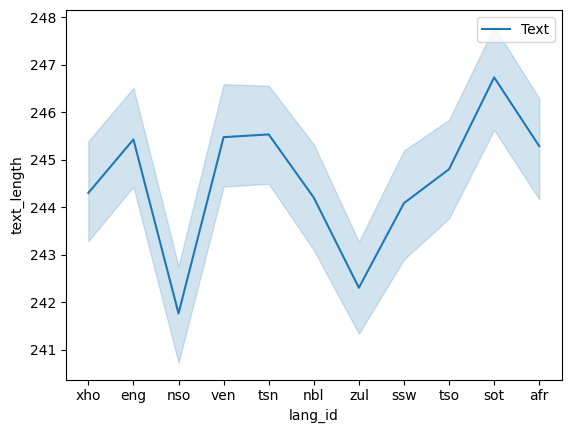

In [62]:
sns.lineplot(data=df_clean, x='lang_id', y='text_length',  label='Text')

In [63]:
# Identify and extract rows with duplicated 'text' and 'language Id'
duplicates = df_clean[df_clean[['text', 'lang_id']].duplicated(keep=False)].count()

# Display the DataFrame containing duplicate rows
duplicates['text']

70

In [64]:
# Count the occurrences of each duplicate texts
text_counts = df_clean['text'].value_counts()

# Display the result
text_counts.head(10)

akunamphumelelo alukho lwati lwetidzingo tetheksthi kubhala umfundzi wehlisa lizinga kunekuhlanhlatsa lokukhulu kuletinye tincenye imibono yetheksthi ayibumbani nalokucuketfwe imbalwa kakhulu imininingwane lesekela sihloko kuhlela nekwakha luhlaka akukho itheksthi yetfulwe kabi              4
sibawa bona ufike eofisini yengaphambi komhlakakuka nakube awuphumeleli ukufika ngalelilanga sibawa uthintane neofisi yezehlalakuhle yangekhenu nikhulumisane ngelinye ilanga ongafika ngalo umrholwakho ungahle ujanyiswe                                                                          2
uma kunesidzingo nelunako ngekuphepha kwakho nobe kwafakazi liphoyisa umshushisi nobe weluphiko lwekuvikela bofakazi utawukhona kukwecwayisa ngalokumele ukwente kute uphephe batawukusita bagcine lapho bangefika khona                                                                            2
bopaki ke bo kgotsofatsang ba hore tema yohle e lekotswe botjha ka sepheo sa ho hlaola diphoso le ho e ntlafatsa kgoka

In [65]:
df_clean = df_clean.drop_duplicates()
df_clean.shape

(29930, 4)

In [66]:
from sklearn.feature_extraction.text import CountVectorizer

In [67]:
vect = CountVectorizer()
vect.fit(df_clean['text'])

CountVectorizer()

In [68]:
vect = CountVectorizer(ngram_range=(1, 2))

In [69]:
vect = CountVectorizer(max_df=0.5)

In [70]:
vect = CountVectorizer(min_df=2)

## Preprocessing the data

## Data Preprocessing

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [81]:
# Preprocess the text data - ensuring that the text data is in lower case
text_col_lower = train_df['text'].apply(lambda x: x.lower())

# Create a pipeline with TF-IDF vectorizer and MultinomialNB
pipeline_vect = Pipeline([('tfidf', TfidfVectorizer()),('nb', MultinomialNB()),])

# Define hyperparameters for tuning
parameters = {
    'tfidf__max_features': (None, 1000, 5000),  # Max_features
    'nb__alpha': (0.1, 0.5, 1.0),  # alpha values for NB
}

# Perform a grid search using 5-fold cross-validation
grid_search = GridSearchCV(pipeline_vect, parameters, cv=5, n_jobs=-1)
grid_search.fit(text_col_lower, train_df['lang_id'])

# Peint the 'Best Parameters' found
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'nb__alpha': 0.1, 'tfidf__max_features': None}


## Training and Evaluation

In [82]:
# Dividing the training dataset into our training variables (x-variables) and our predictive variable (y-variable):
X = train_df['text']
y = train_df['lang_id']

# Split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting sets
print("The shape of X_train is: ", X_train.shape)
print("The shape of X_test is: ", X_test.shape)
print("The shape of y_train is: ", y_train.shape)
print("The shape of y_test is: ", y_test.shape)

The shape of X_train is:  (26400,)
The shape of X_test is:  (6600,)
The shape of y_train is:  (26400,)
The shape of y_test is:  (6600,)


# **Basic Model**

### Logistic Regression

### Naive Bayes

In [83]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

In [85]:
# Step 1: Create pipelines with placeholder parameters for hyperparameter tuning

nb_pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])
lr_pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])

# Step 2: Create parameter grids for hyperparameter tuning
param_grid_nb = {
    'clf__alpha': [0.1, 0.5, 1.0, 2.0]
}

param_grid_lr = {
    'clf__C': [0.1, 1, 10],
    'clf__multi_class': ['ovr', 'multinomial'],
    'clf__solver': ['saga']
}

# Step 3: Create dictionaries for classifiers and their corresponding parameter grids for Naive Bayes & Logistic Regression models

classifiers = {
    'Naive Bayes': (nb_pipeline, param_grid_nb),
    'Logistic Regression': (lr_pipeline, param_grid_lr)
}

results = []

for clf_name, (clf, param_grid) in classifiers.items():
    print(f"Training and tuning hyperparameters for {clf_name}...")

    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Perform the grid search
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters and model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Print the best hyperparameters
    print(f"Best Hyperparameters for {clf_name}: {best_params}")

    # Fit the best model on the entire training set
    best_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {clf_name}: {accuracy:.4f}\n")

    # Save the results
    results.append([clf_name, accuracy, best_params])

# Display the results
for result in results:
    print(result[0], "Accuracy:", result[1])
    print("Best Hyperparameters:", result[2])
    print("="*50)


Training and tuning hyperparameters for Naive Bayes...
Best Hyperparameters for Naive Bayes: {'clf__alpha': 0.1}
Accuracy for Naive Bayes: 0.9991

Training and tuning hyperparameters for Logistic Regression...
Best Hyperparameters for Logistic Regression: {'clf__C': 10, 'clf__multi_class': 'multinomial', 'clf__solver': 'saga'}
Accuracy for Logistic Regression: 0.9965

Naive Bayes Accuracy: 0.9990909090909091
Best Hyperparameters: {'clf__alpha': 0.1}
Logistic Regression Accuracy: 0.9965151515151515
Best Hyperparameters: {'clf__C': 10, 'clf__multi_class': 'multinomial', 'clf__solver': 'saga'}


In [86]:
# Evaluate the models on the test set
test_results = []
test_conf_matrices = {}
test_report_per_class = {}

for clf_name, (clf, _) in classifiers.items():
    print(f"Evaluating {clf_name} on the test set...")

    # Fit the entire pipeline on the training data
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_test_pred = clf.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    report_test = classification_report(y_test, y_test_pred)
    confusion_mat_test = confusion_matrix(y_test, y_test_pred)

    print(f"\n{clf_name} Test Set Classification Report:\n")
    print(f"Accuracy: {accuracy_test:.4f}\n")
    print(report_test)
    print("="*50)

    # Save the results to dictionaries
    test_conf_matrices[clf_name] = confusion_mat_test
    test_report_per_class[clf_name] = report_test

    test_results.append([clf_name, accuracy_test, report_test])

# Display the results in the specified format
for result in test_results:
    print(result[0], "Test Set Accuracy:", result[1])
    print(result[2])
    print("="*50)

Evaluating Naive Bayes on the test set...

Naive Bayes Test Set Classification Report:

Accuracy: 0.9980

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       1.00      1.00      1.00       615
         nbl       0.99      1.00      0.99       583
         nso       1.00      1.00      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       1.00      1.00      1.00       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       1.00      1.00      1.00       609
         zul       1.00      0.99      0.99       590

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600

Evaluating Logistic Regression on the test set...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Test Set Classification Report:

Accuracy: 0.9947

              precision    recall  f1-score   support

         afr       1.00      0.99      0.99       583
         eng       1.00      1.00      1.00       615
         nbl       0.98      0.99      0.99       583
         nso       1.00      0.99      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       0.99      1.00      0.99       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       0.99      1.00      0.99       609
         zul       0.98      0.98      0.98       590

    accuracy                           0.99      6600
   macro avg       0.99      0.99      0.99      6600
weighted avg       0.99      0.99      0.99      6600

Naive Bayes Test Set Accuracy: 0.998030303030303
              precision    recall  f1-score   support

         af

## Generate predictions on the test set

In [87]:
# Prepare 'X_test_data' containing the text data from the test dataset
X_test_data = test_df['text']

# Use Naive Bayes classifier to make predictions
naive_bayes_clf = classifiers['Naive Bayes'][0]
X_test_transformed = naive_bayes_clf.named_steps['tfidf'].transform(X_test_data)
naive_bayes_predictions = naive_bayes_clf.named_steps['clf'].predict(X_test_transformed)

# Create a DataFrame for submission
submission_df = pd.DataFrame({'index': test_df['index'], 'lang_id': naive_bayes_predictions})

# Display the updated submission DataFrame
print(submission_df)

      index lang_id
0         1     tsn
1         2     nbl
2         3     ven
3         4     ssw
4         5     afr
...     ...     ...
5677   5678     eng
5678   5679     nso
5679   5680     sot
5680   5681     sot
5681   5682     nbl

[5682 rows x 2 columns]


## Creating a csv for submission

In [88]:
submission_df.to_csv('sample_submission (2).csv', index=False)

### K Nearest Neighbors (KNN)

### Support Vector Machine